# Using Differential Corrections
### to calculate halo orbits near L1/L2

#### tested on Sun-Earth (default), Earth-Moon (default) system

### Initialization

In [28]:
import orbipy as op
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

In [29]:
# available systems (constant sets for systems)
systems = list(op.crtbp3_model.constants_df.index)
systems

['Sun-Earth (default)',
 'Earth-Moon (default)',
 'Sun-Venus (2026-12-05)',
 'Extreme 0.49']

### User input

In [30]:
# USER: select system
system = systems[0]
system

'Sun-Earth (default)'

In [31]:
# USER: select Lagrange point (L1 or L2)
point_name = 'L2'
print('Halo family calculation near', point_name, 'in', system, 'system')

Halo family calculation near L2 in Sun-Earth (default) system


In [32]:
# USER: set minimum distance to small body in km
# Sun-Earth system: 1000, 1e-12
# Earth-Moon system: 1000, 1e-14

min_dist = 1000
tol = 1e-12

### Models creation

In [33]:
# create model, plotter, scaler
model = op.crtbp3_model(system) #model for calculations
model.integrator.set_params(atol=tol, rtol=tol)
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='m/s')
scale = plotter.scaler

# model with State Transition Matrix for differential corrections
stmmodel = op.crtbp3_model(system, stm=True)
stmmodel.integrator.set_params(atol=tol, rtol=tol)

### Find two initial positions for halo orbits using border correction method and fminbound

In [34]:
Lpoint = model.__getattribute__(point_name)
RL = model.mu1-Lpoint # distance small body-L1/L2
sgn = (1 if RL > 0 else -1)
RL = np.abs(RL)
dx0 = RL/3000 # initial step between initial positions of spacecraft
RL, dx0, sgn

(0.01003473633965013, 3.34491211321671e-06, -1)

In [35]:
# events for border correction method
lp = Lpoint-RL+dx0
rp = Lpoint+RL-dx0

left   = op.eventX(lp, accurate=False)
right  = op.eventX(rp, accurate=False)
down   = op.eventY(-0.5, accurate=False)
up     = op.eventY(0.5, accurate=False)

corr_planes = op.border_correction(model, op.y_direction(), [left], [right, down, up])
detector = op.event_detector(model, [op.eventY(count=2)])

(lp-Lpoint)*model.R, (rp-Lpoint)*model.R

(-1500696.1575595278, 1500696.1575595278)

In [36]:
lst = [0]

# goal function for "brute force" halo orbit search
def goal(z0, x0):
    s0 = model.get_zero_state()
    s0[0] = x0
    s0[2] = z0
    dv = corr_planes.calc_dv(0, s0)
    s0 += dv
    df, ev = detector.prop(s0, 0.0, 100, last_state='last', ret_df=False)
    lst[0] = df
    x1 = ev[-1,4]
    z1 = ev[-1,6]
    return (x0-x1)**2+(z0-z1)**2

In [37]:
# initial settings for optimization routine
z_from = RL/10
z_to = RL
x01 = Lpoint + sgn*RL/2
x02 = x01 - sgn*dx0
#x_from = model.mu1-sgn*dx0
#x_to = model.mu1-sgn*RL/2
#x_from, x_to = min(x_from, x_to), max(x_from, x_to)
#z01 = RL/10
#z02 = RL/10 + dx0

z_from*model.R, z_to*model.R, (x01-Lpoint)*model.R, (x02-Lpoint)*model.R
#(x_from-Lpoint)*model.R, (x_to-Lpoint)*model.R, z01*model.R, z02*model.R

(150119.65564116594, 1501196.5564116593, -750598.278205838, -750097.8793536898)

In [38]:
# find first halo
res1 = fminbound(goal, z_from, z_to, args=(x01,), xtol=1e-16, full_output=True)
z01 = res1[0]
s00 = lst[0][0, 1:].copy()
print(res1, s00)

(0.004698856783205471, 4.819564475861169e-22, 0, 13) [1.00501437 0.         0.00469886 0.         0.01974949 0.        ]


In [39]:
# find second halo
res2 = fminbound(goal, z_from, z_to, args=(x02,), xtol=1e-16, full_output=True)
z02 = res2[0]
print(res2)

(0.004697592573942415, 5.048323362758953e-22, 0, 13)


In [40]:
#(x01-Lpoint)*model.R, (x02-Lpoint)*model.R
z01*model.R, z02*model.R

(702948.9747675385, 702759.8490617853)

In [41]:
# initial angle in XZ plane
alpha0 = np.degrees(np.arctan2(z02-z01,x02-x01))
alpha0

-20.704081414869645

### Differential corrections

In [42]:
# differential correction algorithm
dc = op.differential_correction.from_preset(stmmodel, 'halo')

In [43]:
# initialize "positive" direction of search
states_pos = [s00]
alpha_pos = alpha0
dr_pos = dx0

In [44]:
# calculate up to 10000 orbits
for i in range(10000):
    s0 = states_pos[-1]
    x, z = s0[[0,2]]
    #if ((x-model.mu1)**2+z**2)**0.5 < min_dist/model.R:
    if np.abs(z) < min_dist/model.R:
        print('Minimum distance reached')
        break
    if dr_pos < dx0/1000:
        print('Exit at very small step')
        break
    x1 = x + dr_pos*np.cos(np.radians(alpha_pos))
    z1 = z + dr_pos*np.sin(np.radians(alpha_pos))
    s1 = model.get_zero_state()
    s1[0] = x1
    s1[2] = z1
    s1[4] = s0[4]
    try:
        s2 = dc.shoot(s1, alpha_pos+90)
    except:
        print('[%05d] shooting failed %02d %f %f'%(i, dc.it, alpha_pos, dr_pos*model.R))
        dr_pos *= 0.9
        continue
    x2, z2 = s2[[0,2]]
    d = ((x2-x)**2+(z2-z)**2)**0.5
    if d > 2*dr_pos:
        print('Large step detected:', d*model.R)
        break
    alpha_pos = np.degrees(np.arctan2(z2-z,x2-x))
    states_pos.append(s2[:6].copy())
    print('[%05d] %02d %f %f %f'%(i, dc.it, alpha_pos, dr_pos*model.R, d*model.R))

[00000] 03 -20.701189 500.398852 500.398853
[00001] 03 -20.741361 500.398852 500.398975
[00002] 03 -20.779974 500.398852 500.398966
[00003] 03 -20.818580 500.398852 500.398966
[00004] 03 -20.857174 500.398852 500.398966
[00005] 03 -20.895761 500.398852 500.398966
[00006] 03 -20.934336 500.398852 500.398966
[00007] 03 -20.972902 500.398852 500.398966
[00008] 03 -21.011459 500.398852 500.398965
[00009] 03 -21.050007 500.398852 500.398965
[00010] 03 -21.088544 500.398852 500.398965
[00011] 03 -21.127073 500.398852 500.398965
[00012] 03 -21.165592 500.398852 500.398965
[00013] 03 -21.204101 500.398852 500.398965
[00014] 03 -21.242601 500.398852 500.398965
[00015] 03 -21.281092 500.398852 500.398965
[00016] 03 -21.319573 500.398852 500.398965
[00017] 03 -21.358045 500.398852 500.398965
[00018] 03 -21.396507 500.398852 500.398965
[00019] 03 -21.434960 500.398852 500.398965
[00020] 03 -21.473403 500.398852 500.398965
[00021] 03 -21.511838 500.398852 500.398965
[00022] 03 -21.550263 500.398852

[00202] 03 -28.328029 500.398852 500.398956
[00203] 03 -28.364980 500.398852 500.398956
[00204] 06 -28.401937 500.398852 500.398956
[00205] 03 -28.438880 500.398852 500.398956
[00206] 03 -28.475822 500.398852 500.398956
[00207] 03 -28.512741 500.398852 500.398956
[00208] 03 -28.549669 500.398852 500.398956
[00209] 03 -28.586584 500.398852 500.398956
[00210] 03 -28.623498 500.398852 500.398956
[00211] 03 -28.660392 500.398852 500.398956
[00212] 03 -28.697295 500.398852 500.398956
[00213] 03 -28.734180 500.398852 500.398956
[00214] 03 -28.771058 500.398852 500.398956
[00215] 03 -28.807941 500.398852 500.398956
[00216] 03 -28.844806 500.398852 500.398956
[00217] 03 -28.881667 500.398852 500.398956
[00218] 03 -28.918522 500.398852 500.398956
[00219] 03 -28.955368 500.398852 500.398956
[00220] 03 -28.992213 500.398852 500.398956
[00221] 03 -29.029048 500.398852 500.398956
[00222] 03 -29.065878 500.398852 500.398956
[00223] 03 -29.102698 500.398852 500.398955
[00224] 03 -29.139513 500.398852

[00405] 09 -35.707696 500.398852 500.398950
[00406] 04 -35.743559 500.398852 500.398950
[00407] 04 -35.779415 500.398852 500.398950
[00408] 04 -35.815223 500.398852 500.398950
[00409] 03 -35.851050 500.398852 500.398950
[00410] 03 -35.886853 500.398852 500.398950
[00411] 08 -35.922692 500.398852 500.398950
[00412] 04 -35.958488 500.398852 500.398950
[00413] 05 -35.994352 500.398852 500.398950
[00414] 05 -36.030089 500.398852 500.398949
[00415] 05 -36.065927 500.398852 500.398950
[00416] 03 -36.101756 500.398852 500.398950
[00417] 04 -36.137489 500.398852 500.398949
[00418] 05 -36.173340 500.398852 500.398950
[00419] 03 -36.209068 500.398852 500.398949
[00420] 03 -36.244880 500.398852 500.398950
[00421] 03 -36.280685 500.398852 500.398950
[00422] 03 -36.316409 500.398852 500.398949
[00423] 03 -36.352230 500.398852 500.398950
[00424] 04 -36.387973 500.398852 500.398950
[00425] 03 -36.423736 500.398852 500.398950
[00426] 03 -36.459496 500.398852 500.398950
[00427] 04 -36.495232 500.398852

[00593] 03 -42.389815 500.398852 500.398947
[00594] 03 -42.425149 500.398852 500.398947
[00595] 03 -42.460482 500.398852 500.398947
[00596] 03 -42.495814 500.398852 500.398947
[00597] 03 -42.531144 500.398852 500.398947
[00598] 03 -42.566473 500.398852 500.398947
[00599] 03 -42.601801 500.398852 500.398947
[00600] 03 -42.637128 500.398852 500.398947
[00601] 03 -42.672454 500.398852 500.398947
[00602] 03 -42.707779 500.398852 500.398947
[00603] 03 -42.743103 500.398852 500.398947
[00604] 03 -42.778425 500.398852 500.398947
[00605] 03 -42.813747 500.398852 500.398947
[00606] 03 -42.849067 500.398852 500.398947
[00607] 03 -42.884387 500.398852 500.398947
[00608] 03 -42.919705 500.398852 500.398947
[00609] 03 -42.955022 500.398852 500.398947
[00610] 03 -42.990339 500.398852 500.398947
[00611] 03 -43.025654 500.398852 500.398947
[00612] 03 -43.060969 500.398852 500.398947
[00613] 03 -43.096282 500.398852 500.398947
[00614] 03 -43.131595 500.398852 500.398947
[00615] 03 -43.166907 500.398852

[00782] 03 -49.064490 500.398852 500.398948
[00783] 03 -49.099889 500.398852 500.398948
[00784] 03 -49.135289 500.398852 500.398948
[00785] 03 -49.170692 500.398852 500.398948
[00786] 03 -49.206096 500.398852 500.398948
[00787] 03 -49.241503 500.398852 500.398948
[00788] 03 -49.276912 500.398852 500.398948
[00789] 03 -49.312322 500.398852 500.398948
[00790] 03 -49.347735 500.398852 500.398948
[00791] 03 -49.383150 500.398852 500.398948
[00792] 03 -49.418567 500.398852 500.398948
[00793] 03 -49.453986 500.398852 500.398948
[00794] 03 -49.489408 500.398852 500.398948
[00795] 03 -49.524831 500.398852 500.398948
[00796] 03 -49.560257 500.398852 500.398948
[00797] 03 -49.595685 500.398852 500.398948
[00798] 03 -49.631115 500.398852 500.398948
[00799] 03 -49.666547 500.398852 500.398948
[00800] 03 -49.701982 500.398852 500.398948
[00801] 03 -49.737419 500.398852 500.398948
[00802] 03 -49.772858 500.398852 500.398948
[00803] 03 -49.808300 500.398852 500.398948
[00804] 03 -49.843744 500.398852

[00983] 03 -56.243385 500.398852 500.398952
[00984] 03 -56.279547 500.398852 500.398952
[00985] 03 -56.315714 500.398852 500.398952
[00986] 03 -56.351882 500.398852 500.398952
[00987] 03 -56.388057 500.398852 500.398952
[00988] 03 -56.424242 500.398852 500.398952
[00989] 03 -56.460426 500.398852 500.398952
[00990] 03 -56.496622 500.398852 500.398952
[00991] 03 -56.532819 500.398852 500.398952
[00992] 03 -56.569025 500.398852 500.398952
[00993] 03 -56.605235 500.398852 500.398952
[00994] 03 -56.641452 500.398852 500.398952
[00995] 03 -56.677673 500.398852 500.398952
[00996] 03 -56.713902 500.398852 500.398952
[00997] 03 -56.750136 500.398852 500.398952
[00998] 03 -56.786374 500.398852 500.398952
[00999] 03 -56.822621 500.398852 500.398952
[01000] 03 -56.858872 500.398852 500.398952
[01001] 03 -56.895129 500.398852 500.398952
[01002] 03 -56.931392 500.398852 500.398952
[01003] 03 -56.967661 500.398852 500.398952
[01004] 03 -57.003936 500.398852 500.398952
[01005] 03 -57.040217 500.398852

[01179] 05 -63.459351 500.398852 500.398959
[01180] 03 -63.496874 500.398852 500.398959
[01181] 03 -63.534592 500.398852 500.398961
[01182] 06 -63.572132 500.398852 500.398960
[01183] 08 -63.609687 500.398852 500.398960
[01184] 06 -63.647366 500.398852 500.398960
[01185] 06 -63.685047 500.398852 500.398960
[01186] 04 -63.722630 500.398852 500.398960
[01187] 03 -63.760228 500.398852 500.398960
[01188] 04 -63.797934 500.398852 500.398960
[01189] 03 -63.835644 500.398852 500.398961
[01190] 04 -63.873270 500.398852 500.398960
[01191] 03 -63.910952 500.398852 500.398960
[01192] 03 -63.948644 500.398852 500.398960
[01193] 03 -63.986305 500.398852 500.398960
[01194] 05 -64.024054 500.398852 500.398961
[01195] 04 -64.061772 500.398852 500.398961
[01196] 04 -64.099534 500.398852 500.398961
[01197] 06 -64.137201 500.398852 500.398960
[01198] 09 -64.175012 500.398852 500.398961
[01199] 03 -64.212703 500.398852 500.398960
[01200] 04 -64.250527 500.398852 500.398961
[01201] 03 -64.288254 500.398852

[01392] 02 -71.679959 500.398852 500.398972
[01393] 02 -71.719626 500.398852 500.398972
[01394] 02 -71.759302 500.398852 500.398972
[01395] 02 -71.798989 500.398852 500.398972
[01396] 02 -71.838686 500.398852 500.398972
[01397] 02 -71.878394 500.398852 500.398972
[01398] 02 -71.918112 500.398852 500.398972
[01399] 02 -71.957839 500.398852 500.398972
[01400] 02 -71.997577 500.398852 500.398972
[01401] 02 -72.037326 500.398852 500.398973
[01402] 02 -72.077084 500.398852 500.398973
[01403] 02 -72.116853 500.398852 500.398973
[01404] 02 -72.156632 500.398852 500.398973
[01405] 02 -72.196421 500.398852 500.398973
[01406] 02 -72.236220 500.398852 500.398973
[01407] 02 -72.276030 500.398852 500.398973
[01408] 02 -72.315850 500.398852 500.398973
[01409] 02 -72.355680 500.398852 500.398973
[01410] 02 -72.395520 500.398852 500.398973
[01411] 02 -72.435370 500.398852 500.398973
[01412] 02 -72.475231 500.398852 500.398973
[01413] 02 -72.515101 500.398852 500.398973
[01414] 02 -72.554982 500.398852

[01582] 02 -79.392983 500.398852 500.398983
[01583] 02 -79.434446 500.398852 500.398983
[01584] 02 -79.475917 500.398852 500.398983
[01585] 02 -79.517397 500.398852 500.398983
[01586] 02 -79.558884 500.398852 500.398983
[01587] 02 -79.600380 500.398852 500.398983
[01588] 02 -79.641882 500.398852 500.398983
[01589] 02 -79.683395 500.398852 500.398983
[01590] 02 -79.724913 500.398852 500.398984
[01591] 02 -79.766440 500.398852 500.398984
[01592] 02 -79.807975 500.398852 500.398984
[01593] 02 -79.849517 500.398852 500.398984
[01594] 02 -79.891067 500.398852 500.398984
[01595] 02 -79.932626 500.398852 500.398984
[01596] 02 -79.974192 500.398852 500.398984
[01597] 02 -80.015766 500.398852 500.398984
[01598] 02 -80.057347 500.398852 500.398984
[01599] 02 -80.098936 500.398852 500.398984
[01600] 02 -80.140533 500.398852 500.398984
[01601] 02 -80.182137 500.398852 500.398984
[01602] 02 -80.223749 500.398852 500.398984
[01603] 02 -80.265368 500.398852 500.398984
[01604] 02 -80.306995 500.398852

[01772] 02 -87.385318 500.398852 500.398990
[01773] 02 -87.427688 500.398852 500.398989
[01774] 03 -87.470236 500.398852 500.398990
[01775] 03 -87.512728 500.398852 500.398990
[01776] 04 -87.555274 500.398852 500.398990
[01777] 02 -87.597666 500.398852 500.398989
[01778] 02 -87.640216 500.398852 500.398990
[01779] 02 -87.682765 500.398852 500.398990
[01780] 02 -87.725218 500.398852 500.398989
[01781] 03 -87.767676 500.398852 500.398990
[01782] 02 -87.810274 500.398852 500.398990
[01783] 02 -87.852693 500.398852 500.398989
[01784] 02 -87.895290 500.398852 500.398990
[01785] 02 -87.937718 500.398852 500.398989
[01786] 03 -87.980314 500.398852 500.398990
[01787] 02 -88.022749 500.398852 500.398989
[01788] 02 -88.065307 500.398852 500.398990
[01789] 03 -88.107826 500.398852 500.398990
[01790] 02 -88.150382 500.398852 500.398990
[01791] 03 -88.192868 500.398852 500.398990
[01792] 02 -88.235357 500.398852 500.398990
[01793] 03 -88.277952 500.398852 500.398990
[01794] 04 -88.320411 500.398852

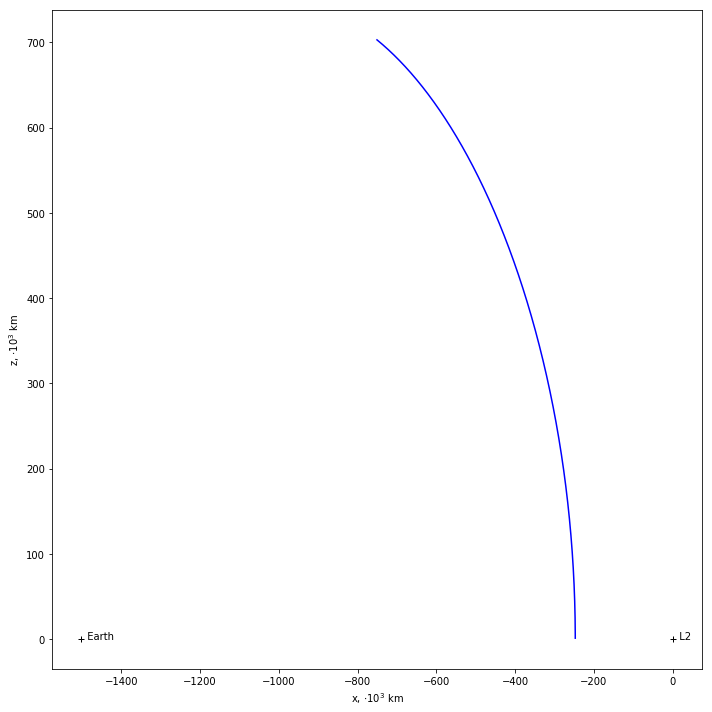

In [45]:
# plot initial states as XZ plane
arr_pos = np.array(states_pos)
df_pos = pd.DataFrame({'x':arr_pos[:,0], 'z':arr_pos[:,2]})
ax = plotter.plot_proj(df_pos, fsize=(10,10), projections=('x-z',), centers={'x':Lpoint}, colors='b')
plotter.plot_proj(plottables=[plotter.m, plotter.__getattribute__(point_name)], 
                  ax=ax, projections=('x-z',), centers={'x':Lpoint}, colors='k', ls='', marker='+');

In [46]:
# initialize "negative" direction of search
states_neg = [s00]
alpha_neg = alpha0+180
dr_neg = dx0

In [47]:
# calculate up to 10000 orbits
for i in range(10000):
    s0 = states_neg[-1]
    x, z = s0[[0,2]]
    if ((x-model.mu1)**2+z**2)**0.5 < min_dist/model.R:
        print('Minimum distance reached')
        break
    if dr_neg < dx0/1000:
        print('Exit at very small step')
        break
    x1 = x + dr_neg*np.cos(np.radians(alpha_neg))
    z1 = z + dr_neg*np.sin(np.radians(alpha_neg))
    s1 = model.get_zero_state()
    s1[0] = x1
    s1[2] = z1
    s1[4] = s0[4]
    try:
        s2 = dc.shoot(s1, alpha_neg+90)
    except:
        dr_neg *= 0.9
        continue
    x2, z2 = s2[[0,2]]
    d = ((x2-x)**2+(z2-z)**2)**0.5
    if d > 2*dr_neg:
        print('Large step detected:', d*model.R)
        dr_neg *= 0.9
        continue
    alpha_neg = np.degrees(np.arctan2(z2-z,x2-x))
    states_neg.append(s2[:6].copy())
    print('[%03d] %02d %f %f %f'%(i, dc.it, alpha_neg, dr_neg*model.R, d*model.R))

[000] 03 159.334348 500.398852 500.398965
[001] 03 159.374539 500.398852 500.398975
[002] 03 159.413191 500.398852 500.398966
[003] 03 159.451855 500.398852 500.398966
[004] 03 159.490525 500.398852 500.398966
[005] 03 159.529209 500.398852 500.398966
[006] 03 159.567899 500.398852 500.398966
[007] 03 159.606599 500.398852 500.398966
[008] 03 159.645313 500.398852 500.398966
[009] 03 159.684030 500.398852 500.398966
[010] 03 159.722762 500.398852 500.398967
[011] 03 159.761502 500.398852 500.398967
[012] 03 159.800254 500.398852 500.398967
[013] 03 159.839011 500.398852 500.398967
[014] 03 159.877779 500.398852 500.398967
[015] 03 159.916560 500.398852 500.398967
[016] 03 159.955352 500.398852 500.398967
[017] 03 159.994148 500.398852 500.398967
[018] 03 160.032954 500.398852 500.398967
[019] 03 160.071775 500.398852 500.398967
[020] 03 160.110604 500.398852 500.398967
[021] 03 160.149446 500.398852 500.398967
[022] 03 160.188288 500.398852 500.398967
[023] 03 160.227149 500.398852 500

[204] 03 167.438010 500.398852 500.398980
[205] 03 167.478908 500.398852 500.398980
[206] 03 167.519819 500.398852 500.398980
[207] 03 167.560742 500.398852 500.398980
[208] 03 167.601679 500.398852 500.398980
[209] 03 167.642628 500.398852 500.398980
[210] 03 167.683589 500.398852 500.398980
[211] 03 167.724563 500.398852 500.398980
[212] 03 167.765549 500.398852 500.398980
[213] 03 167.806548 500.398852 500.398980
[214] 03 167.847560 500.398852 500.398980
[215] 03 167.888584 500.398852 500.398980
[216] 03 167.929622 500.398852 500.398981
[217] 03 167.970671 500.398852 500.398981
[218] 03 168.011734 500.398852 500.398981
[219] 03 168.052809 500.398852 500.398981
[220] 03 168.093897 500.398852 500.398981
[221] 03 168.134998 500.398852 500.398981
[222] 03 168.176112 500.398852 500.398981
[223] 03 168.217238 500.398852 500.398981
[224] 03 168.258377 500.398852 500.398981
[225] 03 168.299529 500.398852 500.398981
[226] 03 168.340694 500.398852 500.398981
[227] 03 168.381871 500.398852 500

[416] 03 176.412795 500.398852 500.398999
[417] 03 176.456698 500.398852 500.398999
[418] 03 176.500616 500.398852 500.398999
[419] 03 176.544551 500.398852 500.398999
[420] 03 176.588501 500.398852 500.398999
[421] 03 176.632468 500.398852 500.398999
[422] 03 176.676450 500.398852 500.399000
[423] 03 176.720448 500.398852 500.399000
[424] 03 176.764463 500.398852 500.399000
[425] 03 176.808493 500.398852 500.399000
[426] 03 176.852539 500.398852 500.399000
[427] 03 176.896602 500.398852 500.399000
[428] 03 176.940680 500.398852 500.399000
[429] 03 176.984775 500.398852 500.399000
[430] 03 177.028885 500.398852 500.399000
[431] 03 177.073012 500.398852 500.399001
[432] 03 177.117155 500.398852 500.399001
[433] 03 177.161314 500.398852 500.399001
[434] 03 177.205489 500.398852 500.399001
[435] 03 177.249680 500.398852 500.399001
[436] 03 177.293888 500.398852 500.399001
[437] 03 177.338112 500.398852 500.399001
[438] 03 177.382353 500.398852 500.399001
[439] 03 177.426610 500.398852 500

[620] 03 -174.277594 500.398852 500.399024
[621] 05 -174.230108 500.398852 500.399024
[622] 05 -174.182536 500.398852 500.399025
[623] 07 -174.135011 500.398852 500.399024
[624] 08 -174.087473 500.398852 500.399024
[625] 03 -174.039845 500.398852 500.399025
[626] 03 -173.992254 500.398852 500.399025
[627] 03 -173.944628 500.398852 500.399025
[628] 03 -173.896983 500.398852 500.399025
[629] 03 -173.849319 500.398852 500.399025
[630] 03 -173.801635 500.398852 500.399025
[631] 03 -173.753931 500.398852 500.399026
[632] 03 -173.706207 500.398852 500.399026
[633] 03 -173.658464 500.398852 500.399026
[634] 03 -173.610701 500.398852 500.399026
[635] 03 -173.562919 500.398852 500.399026
[636] 03 -173.515117 500.398852 500.399026
[637] 03 -173.467295 500.398852 500.399026
[638] 03 -173.419453 500.398852 500.399027
[639] 03 -173.371591 500.398852 500.399027
[640] 03 -173.323710 500.398852 500.399027
[641] 03 -173.275808 500.398852 500.399027
[642] 03 -173.227887 500.398852 500.399027
[643] 03 -1

[823] 03 -164.210394 500.398852 500.399057
[824] 03 -164.158586 500.398852 500.399057
[825] 03 -164.106756 500.398852 500.399057
[826] 03 -164.054904 500.398852 500.399057
[827] 03 -164.003029 500.398852 500.399057
[828] 03 -163.951130 500.398852 500.399057
[829] 03 -163.899210 500.398852 500.399058
[830] 03 -163.847266 500.398852 500.399058
[831] 03 -163.795300 500.398852 500.399058
[832] 03 -163.743311 500.398852 500.399058
[833] 03 -163.691299 500.398852 500.399058
[834] 03 -163.639264 500.398852 500.399058
[835] 03 -163.587206 500.398852 500.399059
[836] 03 -163.535126 500.398852 500.399059
[837] 03 -163.483023 500.398852 500.399059
[838] 03 -163.430897 500.398852 500.399059
[839] 03 -163.378748 500.398852 500.399059
[840] 03 -163.326576 500.398852 500.399060
[841] 03 -163.274381 500.398852 500.399060
[842] 03 -163.222163 500.398852 500.399060
[843] 03 -163.169923 500.398852 500.399060
[844] 03 -163.117659 500.398852 500.399060
[845] 03 -163.065373 500.398852 500.399060
[846] 03 -1

[1021] 03 -153.498750 500.398852 500.399095
[1022] 03 -153.442308 500.398852 500.399095
[1023] 05 -153.385854 500.398852 500.399095
[1024] 06 -153.329340 500.398852 500.399096
[1025] 03 -153.272853 500.398852 500.399095
[1026] 05 -153.216304 500.398852 500.399096
[1027] 05 -153.159744 500.398852 500.399096
[1028] 05 -153.103161 500.398852 500.399096
[1029] 03 -153.046538 500.398852 500.399097
[1030] 04 -152.989942 500.398852 500.399096
[1031] 03 -152.933253 500.398852 500.399097
[1032] 03 -152.876594 500.398852 500.399097
[1033] 03 -152.819914 500.398852 500.399097
[1034] 05 -152.763150 500.398852 500.399098
[1035] 03 -152.706423 500.398852 500.399097
[1036] 03 -152.649653 500.398852 500.399098
[1037] 03 -152.592859 500.398852 500.399098
[1038] 03 -152.536068 500.398852 500.399098
[1039] 07 -152.479177 500.398852 500.399099
[1040] 04 -152.422353 500.398852 500.399098
[1041] 05 -152.365467 500.398852 500.399099
[1042] 04 -152.308528 500.398852 500.399099
[1043] 03 -152.251609 500.398852

[1212] 02 -142.310962 500.398852 500.399132
[1213] 04 -142.250410 500.398852 500.399132
[1214] 04 -142.189803 500.398852 500.399132
[1215] 04 -142.129194 500.398852 500.399132
[1216] 02 -142.068544 500.398852 500.399133
[1217] 05 -142.007933 500.398852 500.399132
[1218] 04 -141.947269 500.398852 500.399133
[1219] 02 -141.886548 500.398852 500.399133
[1220] 04 -141.825876 500.398852 500.399133
[1221] 04 -141.765171 500.398852 500.399133
[1222] 02 -141.704419 500.398852 500.399133
[1223] 02 -141.643667 500.398852 500.399133
[1224] 02 -141.582895 500.398852 500.399134
[1225] 02 -141.522105 500.398852 500.399134
[1226] 02 -141.461297 500.398852 500.399134
[1227] 02 -141.400471 500.398852 500.399134
[1228] 02 -141.339628 500.398852 500.399134
[1229] 02 -141.278767 500.398852 500.399134
[1230] 02 -141.217888 500.398852 500.399135
[1231] 02 -141.156992 500.398852 500.399135
[1232] 02 -141.096078 500.398852 500.399135
[1233] 02 -141.035146 500.398852 500.399135
[1234] 02 -140.974198 500.398852

[1412] 03 -129.911088 500.398852 500.399154
[1413] 03 -129.848157 500.398852 500.399154
[1414] 03 -129.785224 500.398852 500.399154
[1415] 03 -129.722287 500.398852 500.399154
[1416] 03 -129.659348 500.398852 500.399154
[1417] 03 -129.596405 500.398852 500.399154
[1418] 03 -129.533460 500.398852 500.399154
[1419] 03 -129.470512 500.398852 500.399154
[1420] 03 -129.407561 500.398852 500.399154
[1421] 03 -129.344609 500.398852 500.399154
[1422] 03 -129.281654 500.398852 500.399154
[1423] 03 -129.218695 500.398852 500.399154
[1424] 03 -129.155738 500.398852 500.399154
[1425] 03 -129.092775 500.398852 500.399154
[1426] 03 -129.029810 500.398852 500.399154
[1427] 02 -128.966845 500.398852 500.399154
[1428] 03 -128.903883 500.398852 500.399154
[1429] 03 -128.840911 500.398852 500.399154
[1430] 04 -128.777941 500.398852 500.399154
[1431] 02 -128.714966 500.398852 500.399154
[1432] 03 -128.651995 500.398852 500.399154
[1433] 05 -128.589030 500.398852 500.399154
[1434] 03 -128.526040 500.398852

[1607] 03 -117.719376 500.398852 500.399139
[1608] 03 -117.658039 500.398852 500.399139
[1609] 04 -117.596752 500.398852 500.399138
[1610] 03 -117.535483 500.398852 500.399138
[1611] 04 -117.474216 500.398852 500.399138
[1612] 03 -117.412979 500.398852 500.399138
[1613] 03 -117.351763 500.398852 500.399138
[1614] 03 -117.290569 500.398852 500.399138
[1615] 03 -117.229397 500.398852 500.399137
[1616] 03 -117.168246 500.398852 500.399137
[1617] 03 -117.107117 500.398852 500.399137
[1618] 03 -117.046010 500.398852 500.399137
[1619] 03 -116.984925 500.398852 500.399137
[1620] 03 -116.923863 500.398852 500.399136
[1621] 03 -116.862823 500.398852 500.399136
[1622] 03 -116.801805 500.398852 500.399136
[1623] 03 -116.740810 500.398852 500.399136
[1624] 03 -116.679838 500.398852 500.399135
[1625] 03 -116.618889 500.398852 500.399135
[1626] 03 -116.557963 500.398852 500.399135
[1627] 03 -116.497060 500.398852 500.399135
[1628] 03 -116.436181 500.398852 500.399135
[1629] 03 -116.375325 500.398852

[1802] 03 -106.316807 500.398852 500.399081
[1803] 03 -106.262028 500.398852 500.399081
[1804] 03 -106.207296 500.398852 500.399080
[1805] 03 -106.152610 500.398852 500.399080
[1806] 03 -106.097969 500.398852 500.399080
[1807] 03 -106.043375 500.398852 500.399079
[1808] 03 -105.988827 500.398852 500.399079
[1809] 03 -105.934325 500.398852 500.399079
[1810] 03 -105.879870 500.398852 500.399078
[1811] 03 -105.825461 500.398852 500.399078
[1812] 03 -105.771099 500.398852 500.399077
[1813] 03 -105.716784 500.398852 500.399077
[1814] 03 -105.662516 500.398852 500.399077
[1815] 03 -105.608295 500.398852 500.399076
[1816] 03 -105.554120 500.398852 500.399076
[1817] 03 -105.499994 500.398852 500.399075
[1818] 03 -105.445914 500.398852 500.399075
[1819] 04 -105.391882 500.398852 500.399075
[1820] 04 -105.337896 500.398852 500.399074
[1821] 04 -105.283964 500.398852 500.399074
[1822] 03 -105.230068 500.398852 500.399074
[1823] 04 -105.176236 500.398852 500.399073
[1824] 03 -105.122431 500.398852

[1991] 03 -96.893997 500.398852 500.399002
[1992] 03 -96.849693 500.398852 500.399002
[1993] 03 -96.805453 500.398852 500.399001
[1994] 03 -96.761278 500.398852 500.399001
[1995] 03 -96.717167 500.398852 500.399000
[1996] 03 -96.673120 500.398852 500.399000
[1997] 03 -96.629137 500.398852 500.399000
[1998] 03 -96.585219 500.398852 500.398999
[1999] 03 -96.541365 500.398852 500.398999
[2000] 03 -96.497576 500.398852 500.398998
[2001] 03 -96.453852 500.398852 500.398998
[2002] 03 -96.410193 500.398852 500.398997
[2003] 03 -96.366598 500.398852 500.398997
[2004] 03 -96.323069 500.398852 500.398997
[2005] 03 -96.279604 500.398852 500.398996
[2006] 03 -96.236205 500.398852 500.398996
[2007] 03 -96.192870 500.398852 500.398995
[2008] 03 -96.149601 500.398852 500.398995
[2009] 03 -96.106398 500.398852 500.398994
[2010] 03 -96.063261 500.398852 500.398994
[2011] 05 -96.020185 500.398852 500.398994
[2012] 04 -95.977179 500.398852 500.398993
[2013] 03 -95.934243 500.398852 500.398993
[2014] 04 -

[2192] 03 -89.383006 500.398852 500.398920
[2193] 05 -89.353202 500.398852 500.398920
[2194] 03 -89.323478 500.398852 500.398919
[2195] 05 -89.293837 500.398852 500.398919
[2196] 05 -89.264276 500.398852 500.398919
[2197] 04 -89.234797 500.398852 500.398918
[2198] 03 -89.205403 500.398852 500.398918
[2199] 03 -89.176085 500.398852 500.398918
[2200] 03 -89.146851 500.398852 500.398917
[2201] 03 -89.117699 500.398852 500.398917
[2202] 03 -89.088629 500.398852 500.398917
[2203] 03 -89.059641 500.398852 500.398916
[2204] 03 -89.030735 500.398852 500.398916
[2205] 03 -89.001911 500.398852 500.398915
[2206] 03 -88.973170 500.398852 500.398915
[2207] 03 -88.944512 500.398852 500.398915
[2208] 03 -88.915936 500.398852 500.398914
[2209] 03 -88.887442 500.398852 500.398914
[2210] 03 -88.859032 500.398852 500.398914
[2211] 03 -88.830705 500.398852 500.398913
[2212] 03 -88.802460 500.398852 500.398913
[2213] 04 -88.774298 500.398852 500.398913
[2214] 04 -88.746222 500.398852 500.398912
[2215] 06 -

[2386] 04 -85.295506 500.398852 500.398861
[2387] 04 -85.284589 500.398852 500.398861
[2388] 04 -85.273796 500.398852 500.398861
[2389] 04 -85.263128 500.398852 500.398861
[2390] 04 -85.252585 500.398852 500.398861
[2391] 05 -85.242168 500.398852 500.398860
[2392] 04 -85.231877 500.398852 500.398860
[2393] 04 -85.221713 500.398852 500.398860
[2394] 04 -85.211678 500.398852 500.398860
[2395] 04 -85.201767 500.398852 500.398860
[2396] 04 -85.191987 500.398852 500.398859
[2397] 04 -85.182336 500.398852 500.398859
[2398] 04 -85.172814 500.398852 500.398859
[2399] 04 -85.163421 500.398852 500.398859
[2400] 04 -85.154159 500.398852 500.398859
[2401] 04 -85.145028 500.398852 500.398858
[2402] 04 -85.136028 500.398852 500.398858
[2403] 04 -85.127161 500.398852 500.398858
[2404] 04 -85.118425 500.398852 500.398858
[2405] 04 -85.109824 500.398852 500.398858
[2406] 04 -85.101356 500.398852 500.398858
[2407] 04 -85.093022 500.398852 500.398857
[2408] 04 -85.084823 500.398852 500.398857
[2409] 04 -

[2579] 11 -86.304457 265.932466 265.932481
Large step detected: 310291.863649398
[2581] 10 -86.322723 239.339220 239.339232
[2582] 09 -86.340217 239.339220 239.339231
[2583] 09 -86.357896 239.339220 239.339231
[2584] 14 -86.375765 239.339220 239.339231
Large step detected: 301693.75464470184
[2586] 09 -86.392915 215.405298 215.405307
[2587] 09 -86.409327 215.405298 215.405307
[2588] 09 -86.425898 215.405298 215.405307
[2589] 10 -86.442632 215.405298 215.405307
[2590] 11 -86.459530 215.405298 215.405307
Large step detected: 291801.88445658894
[2592] 11 -86.475737 193.864768 193.864776
[2593] 09 -86.491234 193.864768 193.864775
[2594] 09 -86.506870 193.864768 193.864775
[2595] 10 -86.522647 193.864768 193.864775
[2596] 13 -86.538568 193.864768 193.864775
Large step detected: 282787.51002302335
[2598] 10 -86.553827 174.478291 174.478297
[2599] 09 -86.568406 174.478291 174.478297
[2600] 09 -86.583107 174.478291 174.478297
[2601] 10 -86.597931 174.478291 174.478297
[2602] 10 -86.612879 174.

Large step detected: 160493.4732768596
[2781] 10 -87.844076 23.569430 23.569430
[2782] 10 -87.848056 23.569430 23.569430
[2783] 11 -87.852045 23.569430 23.569430
[2784] 09 -87.856043 23.569430 23.569430
[2785] 10 -87.860050 23.569430 23.569430
[2786] 09 -87.864067 23.569430 23.569430
[2787] 09 -87.868093 23.569430 23.569430
[2788] 14 -87.872129 23.569430 23.569430
[2789] 10 -87.876175 23.569430 23.569430
Large step detected: 157585.2038177866
[2791] 09 -87.880027 21.212487 21.212487
[2792] 09 -87.883684 21.212487 21.212487
[2793] 10 -87.887349 21.212487 21.212487
[2794] 09 -87.891022 21.212487 21.212487
[2795] 12 -87.894703 21.212487 21.212487
[2796] 10 -87.898392 21.212487 21.212487
[2797] 13 -87.902089 21.212487 21.212487
[2798] 12 -87.905794 21.212487 21.212487
[2799] 16 -87.909507 21.212487 21.212487
[2800] 10 -87.913228 21.212487 21.212487
[2801] 09 -87.916958 21.212487 21.212487
[2802] 10 -87.920695 21.212487 21.212487
[2803] 12 -87.924441 21.212487 21.212487
[2804] 10 -87.928195

[2985] 09 -88.365984 7.396337 7.396337
[2986] 14 -88.367717 7.396337 7.396337
[2987] 16 -88.369450 7.396337 7.396337
[2988] 13 -88.371186 7.396337 7.396337
[2989] 11 -88.372924 7.396337 7.396337
[2990] 10 -88.374666 7.396337 7.396337
[2991] 18 -88.376407 7.396337 7.396337
[2992] 26 -88.378152 7.396337 7.396337
[2993] 21 -88.379897 7.396337 7.396337
[2994] 13 -88.381647 7.396337 7.396337
[2996] 09 -88.383311 6.656703 6.656703
[2997] 10 -88.384887 6.656703 6.656703
[2998] 14 -88.386467 6.656703 6.656703
[2999] 09 -88.388048 6.656703 6.656703
[3000] 15 -88.389630 6.656703 6.656703
[3001] 24 -88.391215 6.656703 6.656703
[3002] 19 -88.392801 6.656703 6.656703
[3003] 18 -88.394388 6.656703 6.656703
[3004] 10 -88.395981 6.656703 6.656703
[3005] 13 -88.397569 6.656703 6.656703
[3006] 21 -88.399164 6.656703 6.656703
[3007] 09 -88.400759 6.656703 6.656703
[3008] 14 -88.402355 6.656703 6.656703
[3009] 09 -88.403954 6.656703 6.656703
[3010] 11 -88.405554 6.656703 6.656703
[3011] 19 -88.407156 6.65

In [48]:
dist_to_m = ((x-model.mu1)**2+z**2)**0.5*model.R
print('Closest distance to small body:', dist_to_m)

Closest distance to small body: 2702.127543423522


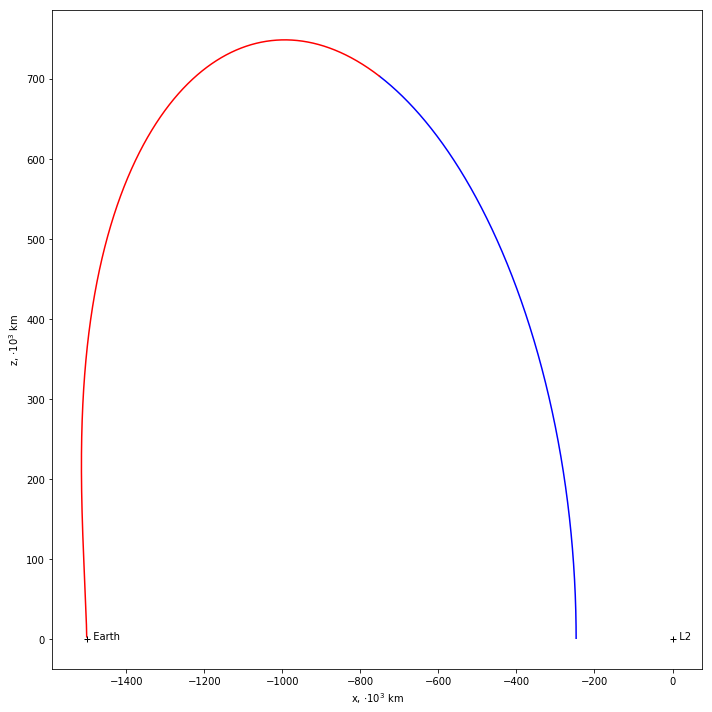

In [49]:
# plot all initial states as XZ plane
arr_neg = np.array(states_neg[1:])
arr_pos = np.array(states_pos)
df_neg = pd.DataFrame({'x':arr_neg[:,0], 'z':arr_neg[:,2]})
df_pos = pd.DataFrame({'x':arr_pos[:,0], 'z':arr_pos[:,2]})
ax = plotter.plot_proj(df_pos, fsize=(10,10), projections=('x-z',), centers={'x':Lpoint}, colors='b')
plotter.plot_proj(df_neg, ax=ax, projections=('x-z',), centers={'x':Lpoint}, colors='r')
plotter.plot_proj(plottables=[plotter.m, plotter.__getattribute__(point_name)], 
                  ax=ax, projections=('x-z',), centers={'x':Lpoint}, colors='k', ls='', marker='+');

#plt.plot((arr_neg[:,0]-Lpoint)*model.R, arr_neg[:,2]*model.R, 'r.')
#plt.plot((arr_pos[:,0]-Lpoint)*model.R, arr_pos[:,2]*model.R, '.')

In [50]:
# combine 'positive' and 'negative' search results into one array
arr = np.vstack((arr_neg[::-1], arr_pos))
arr.shape

(4974, 6)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

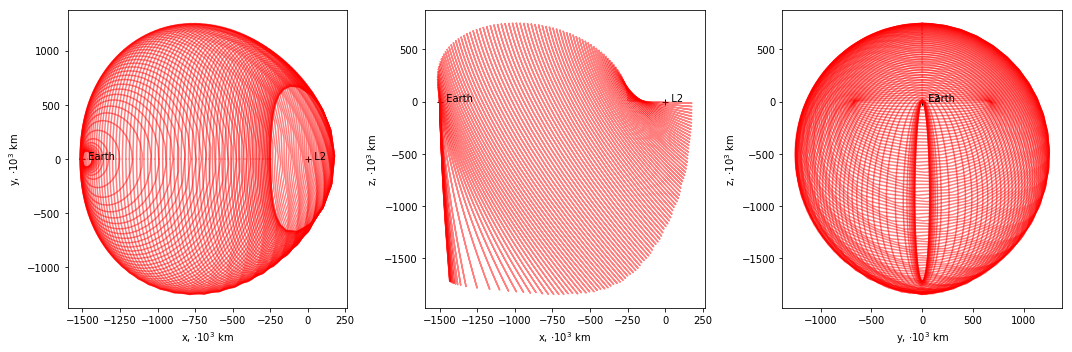

In [51]:
# plot some orbits
ax = plotter.plot_proj(plottables=[plotter.m, plotter.__getattribute__(point_name)], 
                       centers={'x':Lpoint}, colors='k', ls='', marker='+');

for i, s0 in enumerate(arr[::50]):
    df, _ = detector.prop(s0, 0, 100, last_state='last')
    plotter.plot_proj(df, ax=ax, centers={'x':Lpoint}, colors='r', alpha=0.5)
    print(i, end=' ')


In [52]:
# generate file name
fname = 'SH_' + point_name + '_' + model.const_set + '.csv'
fname

'SH_L2_Sun-Earth (default).csv'

In [53]:
header = '''Content: South Halo orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Using Differential Corrections.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: %s
Lagrange point: %s
Columns: %s'''%(model.const_set, point_name, list(op.mapper.columns[1:]))
print(header)

Content: South Halo orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Using Differential Corrections.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: Sun-Earth (default)
Lagrange point: L2
Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz']


In [54]:
# save results to csv
np.savetxt(fname, arr, header=header)